In [2]:
import kagglehub
crowdflower_twitter_airline_sentiment_path = kagglehub.dataset_download('crowdflower/twitter-airline-sentiment')
cosmos98_twitter_and_reddit_sentimental_analysis_dataset_path = kagglehub.dataset_download('cosmos98/twitter-and-reddit-sentimental-analysis-dataset')
seriousran_appletwittersentimenttexts_path = kagglehub.dataset_download('seriousran/appletwittersentimenttexts')
ankurzing_sentiment_analysis_for_financial_news_path = kagglehub.dataset_download('ankurzing/sentiment-analysis-for-financial-news')
surajkum1198_twitterdata_path = kagglehub.dataset_download('surajkum1198/twitterdata')

print('Data source import complete.')

Data source import complete.


## Overview

This notebook performs EDA and then preprocesses multiple datasets to train a bidirectional LSTM model which is used to predict the sentiments behind tweets fetched in real time using `tweepy` and classify them as positive, negative or neutral.

## Installs and Imports

In [3]:
!pip install tweepy

In [4]:
import numpy as np
import pandas as pd
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## EDA

### Cleaning and prepping dataset

In [6]:
# Load Tweet dataset
df1 = pd.read_csv(cosmos98_twitter_and_reddit_sentimental_analysis_dataset_path + '/Twitter_Data.csv')
# Output first five rows
df1.head()

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [8]:
# Load Tweet dataset
df2 = pd.read_csv(seriousran_appletwittersentimenttexts_path + '/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
# Output first five rows

df2.head()

clean_text  category
0  Wow. Yall needa step it up @Apple RT @heynyla:...      -1.0
1  What Happened To Apple Inc?   http://t.co/FJEX...       0.0
2  Thank u @apple I can now compile all of the pi...       1.0
3  The oddly uplifting story of the Apple co-foun...       0.0
4  @apple can i exchange my iphone for a differen...       0.0

The `category` column is our label & has 3 values:
1. 0 Indicating it is a Neutral Sentiment
2. 1 Indicating a Postive Sentiment
3. -1 Indicating a Negative Sentiment

In [10]:
# Load Tweet dataset
df3 = pd.read_csv(surajkum1198_twitterdata_path + '/finalSentimentdata2.csv')
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df3 = df3.drop(['Unnamed: 0'], axis=1)
# Output first five rows
df3.head()

category                                         clean_text
0      -1.0  agree the poor in india are treated badly thei...
1       1.0  if only i could have spent the with this cutie...
2       1.0  will nature conservation remain a priority in ...
3      -1.0  coronavirus disappearing in italy show this to...
4      -1.0  uk records lowest daily virus death toll since...

In [12]:
# Load Tweet dataset
df4 = pd.read_csv(crowdflower_twitter_airline_sentiment_path + '/Tweets.csv')
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['category','clean_text']]
# Output first five rows
df4.head()

category                                         clean_text
0       0.0                @VirginAmerica What @dhepburn said.
1       1.0  @VirginAmerica plus you've added commercials t...
2       0.0  @VirginAmerica I didn't today... Must mean I n...
3      -1.0  @VirginAmerica it's really aggressive to blast...
4      -1.0  @VirginAmerica and it's a really big bad thing...

In [13]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [14]:
# Check for missing data
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [15]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [16]:
# dimensionality of the data
df.shape

(182329, 2)

In [17]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

clean_text  category
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive

## Data Visualisation

In [18]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [19]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

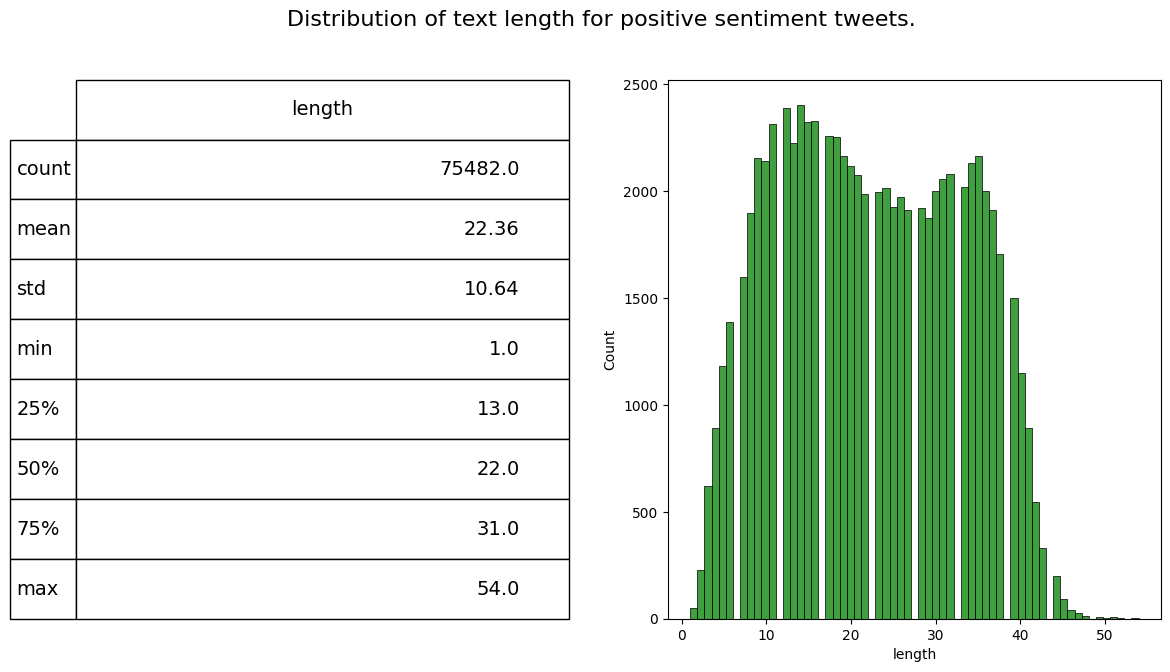

In [20]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

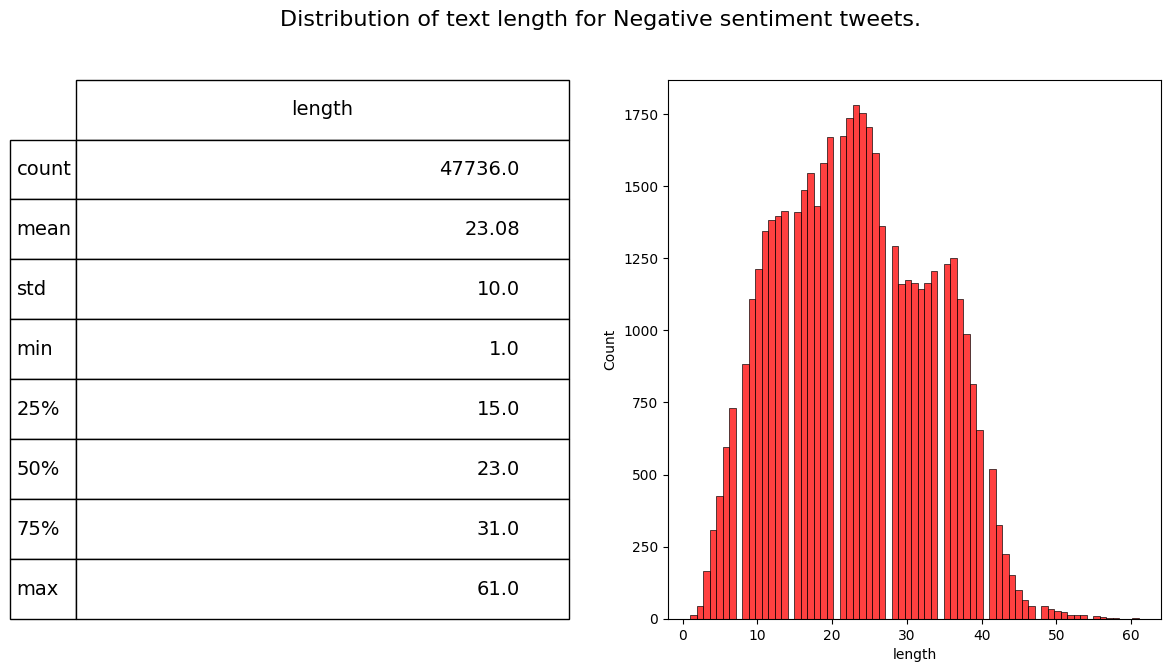

In [21]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

In [22]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [23]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...  Negative
1       talk all the nonsense and continue all the dra...   Neutral
2       what did just say vote for modi  welcome bjp t...  Positive
3       asking his supporters prefix chowkidar their n...  Positive
4       answer who among these the most powerful world...  Positive
...                                                   ...       ...
182335  @AmericanAir thank you we got on a different f...  Positive
182336  @AmericanAir leaving over 20 minutes Late Flig...  Negative
182337  @AmericanAir Please bring American Airlines to...   Neutral
182338  @AmericanAir you have my money, you change my ...  Negative
182339  @AmericanAir we have 8 ppl so we need 2 know h...   Neutral

[182329 rows x 2 columns]>

#### Visualizing data into wordclouds

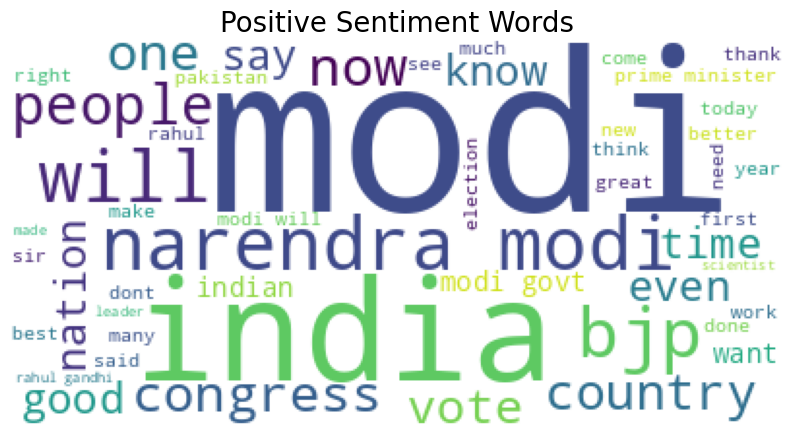

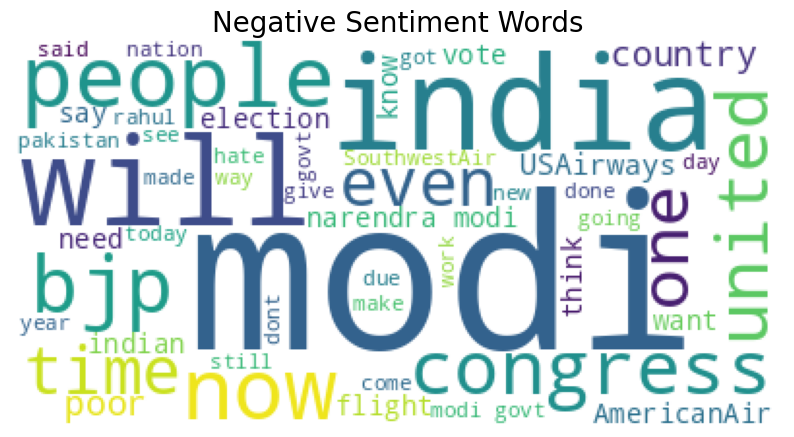

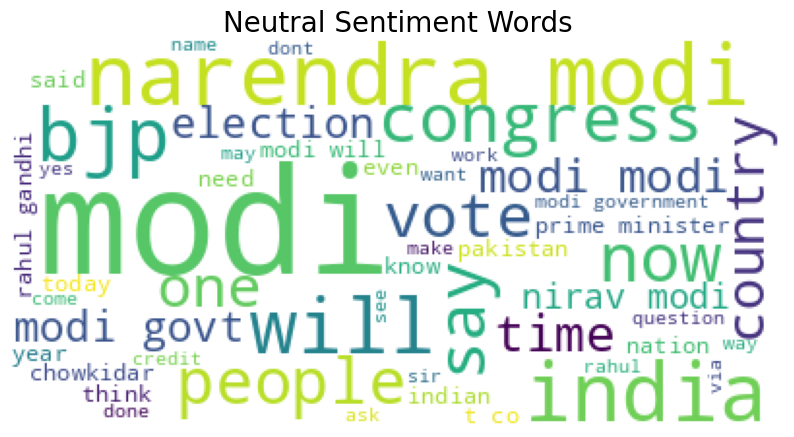

In [24]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')

# Negative tweet words
wordcount_gen(df, 'Negative')

# Neutral tweet words
wordcount_gen(df, 'Neutral')



Dataset is indian tweets so we notice some weird things like "modi" which is the name of the prime minister of india.

## Data Preprocessing

In [25]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [26]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [27]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [28]:
print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


### Train and test split

In [29]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Bag of words (BOW) feature extraction

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [32]:
# print first 200 words/tokens
print(count_vector.get_feature_names_out()[0:200])

['0' '000' '1' '10' '100' '1000' '10000' '10th' '11' '111' '1145' '11th'
 '12' '1200' '12000' '125' '12k' '130' '140' '14000' '15' '150' '1500'
 '1500000' '1520' '157200000' '15l' '15lac' '15lakh' '18' '180' '19'
 '1947' '1958' '1962' '1969' '1971' '1980' '1984' '1998' '1st' '2' '20'
 '200' '2000' '2002' '2004' '2007' '2008' '2009' '2010' '2011' '2012'
 '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2022' '2024'
 '2029' '21st' '23' '23rd' '24' '247' '24x7' '25' '250' '2611' '26th'
 '272' '27th' '280319' '282' '28th' '2cr' '2day' '2nd' '3' '30' '300'
 '3000' '30000' '300km' '31st' '350' '35a' '370' '3rd' '4' '40' '400'
 '4000' '45' '456' '4th' '5' '50' '500' '5000' '50000' '5th' '5year' '5yr'
 '6' '60' '600' '6000' '6th' '7' '72000' '7200000' '72k' '7th' '8' '80'
 '800' '8020' '9' '90' '9000' 'aa' 'aadhaar' 'aadhar' 'aadmi' 'aag' 'aaj'
 'aalo' 'aam' 'aan' 'aap' 'aapk' 'aapko' 'aapl' 'aapn' 'aay' 'aaya'
 'aayega' 'aayog' 'abandon' 'abdul' 'abdullah' 'abe' 'abhi' 'abhinandan'
 '

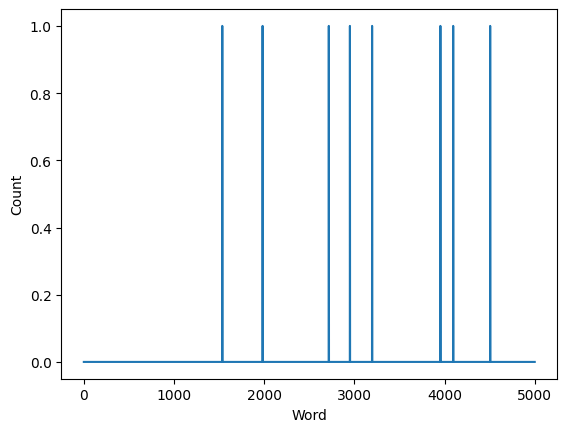

In [33]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Tokenizing & Padding

In [35]:
!pip install keras

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  41    1  349   73 1911 1180   44 2465    2 1259  219    2  236   32
  165  102   53   55 1184  236   50    3    6  533    3   50 3833    3
 3077    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Saving tokenized data

In [39]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [40]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (109397, 50) (109397, 3)
Validation Set -> (36466, 50) (36466, 3)
Test Set -> (36466, 50) (36466, 3)


In [41]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

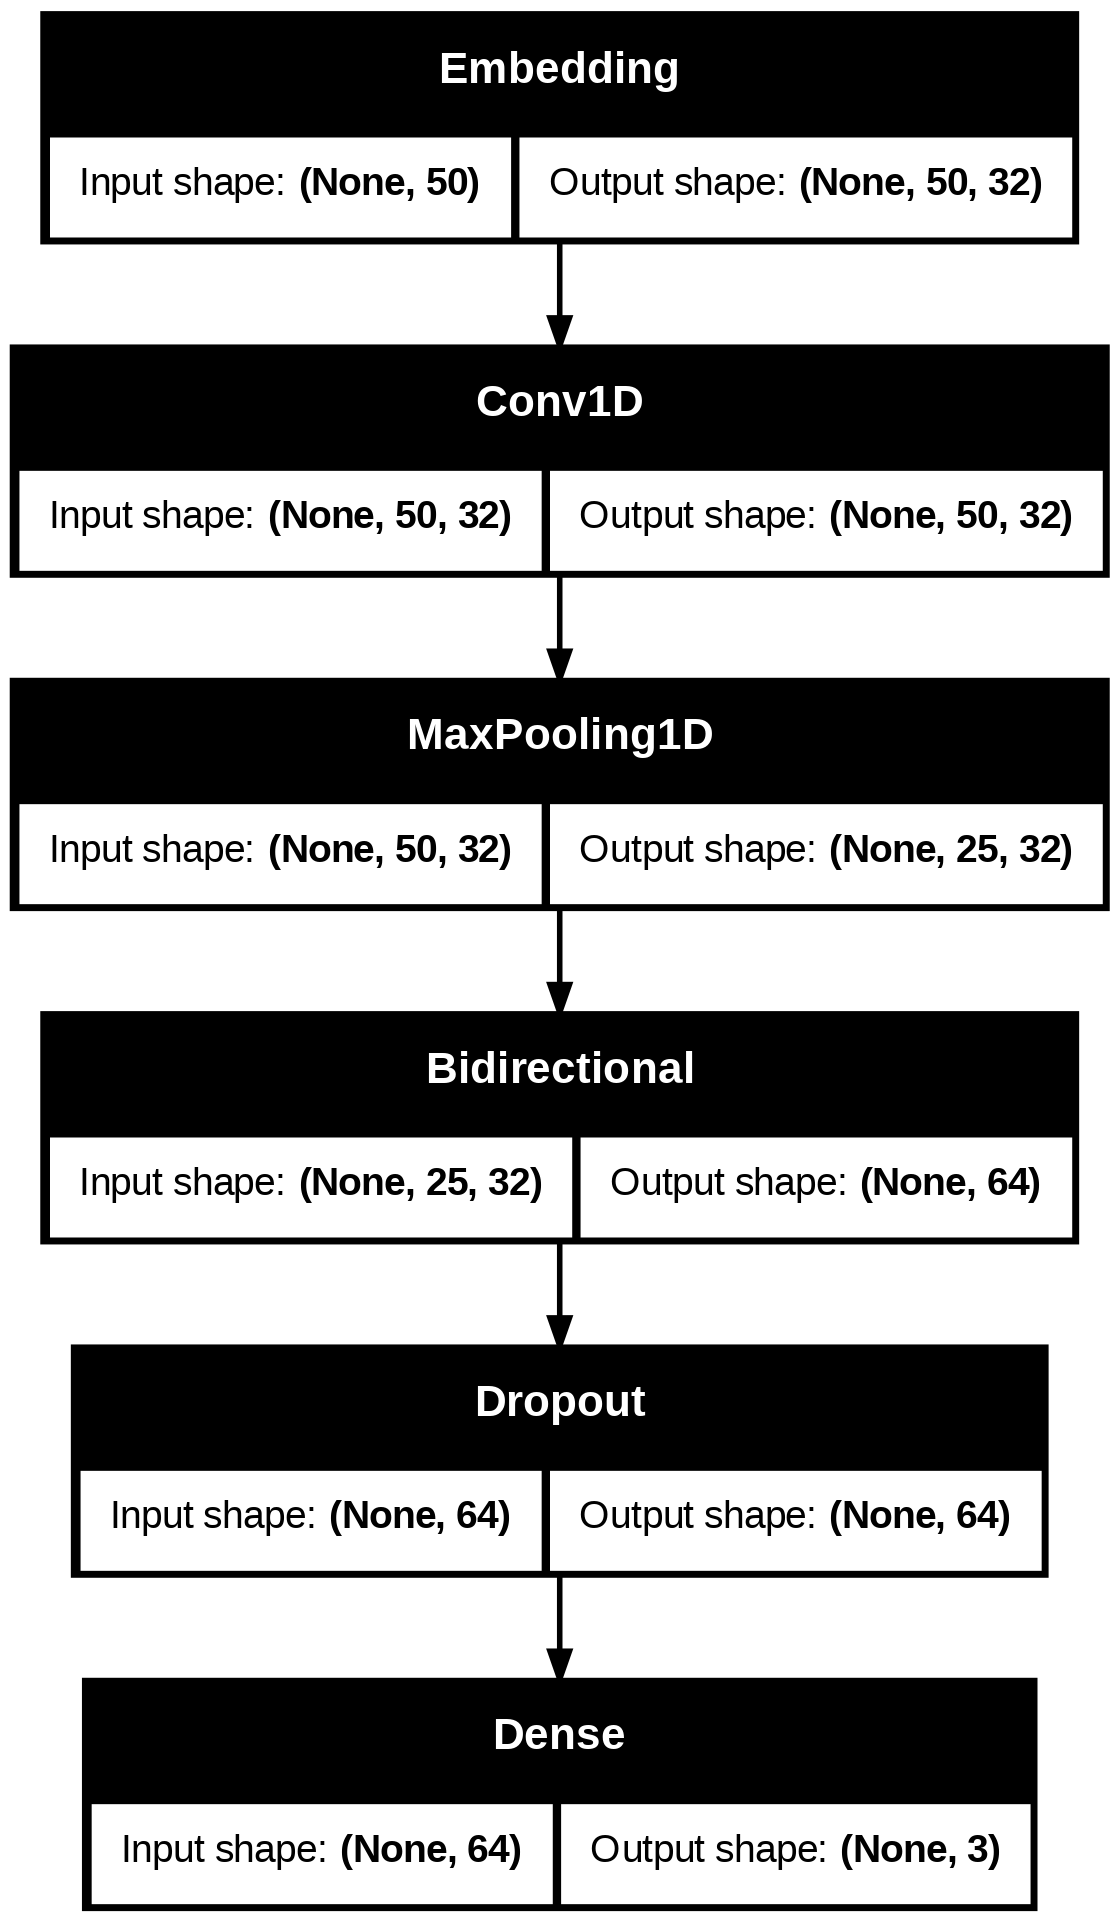

In [45]:
import tensorflow as tf
model.build(input_shape=(None, max_len)) # Build the model with the input shape
tf.keras.utils.plot_model(model, show_shapes=True)

In [46]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 32)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,939 (702.89 KB)

 Trainable params: 179,939 (702.89 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 71s 39ms/step - accuracy: 0.5556 - loss: 0.9028 - precision: 0.6382 - recall: 0.3454 - val_accuracy: 0.8849 - val_loss: 0.3457 - val_precision: 0.8890 - val_recall: 0.8807
Epoch 2/20
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 86s 41ms/step - accuracy: 0.9028 - loss: 0.3227 - precision: 0.9082 - recall: 0.8970 - val_accuracy: 0.9194 - val_loss: 0.2620 - val_precision: 0.9247 - val_recall: 0.9136
Epoch 3/20
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step - accuracy: 0.9203 - loss: 0.2679 - precision: 0.9274 - recall: 0.9131 - val_accuracy: 0.9254 - val_loss: 0.2441 - val_precision: 0.9327 - val_recall: 0.9175
Epoch 4/20
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 87s 41ms/step - accuracy: 0.9256 - loss: 0.2501 - precision: 0.9332 - recall: 0.9176 - val_accuracy: 0.9289 - val_loss: 0.2327 - val_precision: 0.9372 - val_recall: 0.9204
Epoch 5/20
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 69s 41ms/step - accuracy: 0.9310 - loss: 0.2315 - precision: 0.9386 - recall: 0.9237 - val_accura

### Model Accuracy & Loss

In [47]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9231
Precision : 0.9273
Recall    : 0.9198
F1 Score  : 0.9235


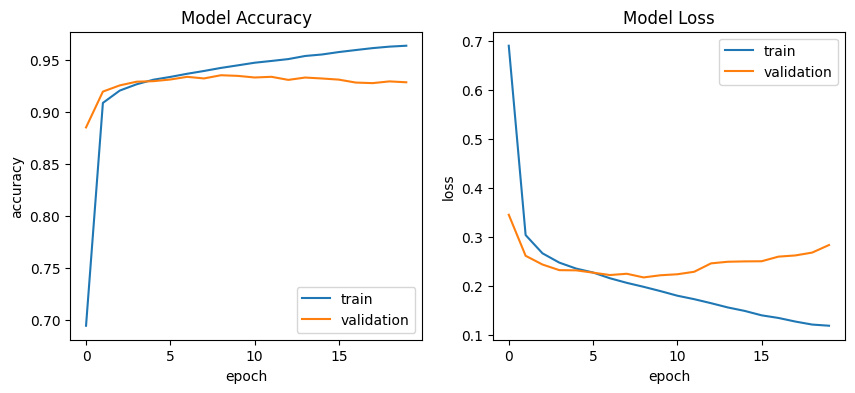

In [48]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

### Model Confusion Matrix

1140/1140 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


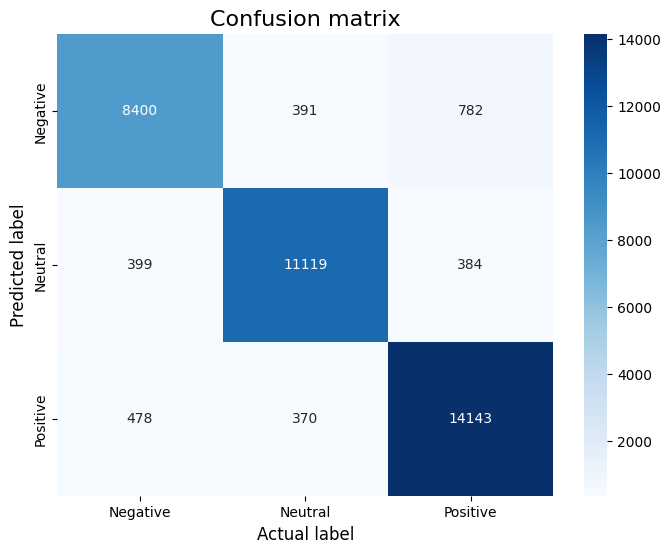

In [49]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [50]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [51]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [52]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
The predicted sentiment is Negative


In [53]:
predict_class(['The food was meh'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
The predicted sentiment is Negative


In [55]:
predict_class(['He is the best minister india ever had seen'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
The predicted sentiment is Positive


In [61]:
predict_class(['I have maths homework'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
The predicted sentiment is Neutral
